In [1]:
import re
import string
import os
import gc
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime as dt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sqlalchemy.engine.base import Engine
from yaml import safe_load

from database.database import engine
from config.config import PG_USER, PG_PASS, PG_HOST, PG_PORT, PG_DB


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [2]:
def select(query: str, conn: Engine=engine) -> pd.DataFrame:
    return pd.read_sql(query, conn)
    
users_query = "SELECT * FROM public.user_data"
posts_query = "SELECT * FROM public.post_text_df"
feeds_query = "SELECT * FROM public.feed_data WHERE action = 'view' LIMIT 5000000"

users_df = select(users_query)
posts_df = select(posts_query)
feeds_df = select(feeds_query)

users_df.to_csv("./postgres/init_data/users.csv", sep=",", index=False)
posts_df.to_csv("./postgres/init_data/posts.csv", sep=",", index=False)
feeds_df.to_csv("./postgres/init_data/feeds.csv", sep=",", index=False)

In [3]:
users_df.shape, posts_df.shape, feeds_df.shape

((163205, 8), (7023, 3), (5000000, 5))

In [4]:
posts_df.head(2)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufacturing sector will continue to face serious chall...,business
1,2,Aids and climate top Davos agenda\n\nClimate change and the fight against Aids are leading the l...,business


In [5]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocessing(text):
    tokens_list = word_tokenize(text.lower())
    punctuation_free = [token for token in tokens_list if token not in punctuation]
    stop_words_free = [token for token in punctuation_free if token not in stop_words]
    digits_free = [token for token in stop_words_free if not re.search(r'\d', token)]
    lemmatized = " ".join([lemmatizer.lemmatize(word) for word in digits_free]) 
    return lemmatized


vectorizer = TfidfVectorizer(preprocessor=preprocessing)
transformed_output = vectorizer.fit_transform(posts_df['text']).toarray()
tfidf_df = pd.DataFrame(
    transformed_output,
    index=posts_df.post_id,
    columns=vectorizer.get_feature_names_out())

posts_df['TotalTfIdf'] = tfidf_df.sum(axis=1).reset_index()[0]
posts_df['MaxTfIdf'] = tfidf_df.max(axis=1).reset_index()[0]
posts_df['MeanTfIdf'] = tfidf_df.mean(axis=1).reset_index()[0]


centered = tfidf_df - tfidf_df.mean(axis=0)
pca = PCA(n_components=30)
pca_decomp = pca.fit_transform(centered)


kmeans = KMeans(n_clusters=20, random_state=0).fit(pca_decomp)
posts_df['TextCluster'] = kmeans.labels_
dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster',
                 'DistanceTo16thCluster',
                 'DistanceTo17thCluster',
                 'DistanceTo18thCluster',
                 'DistanceTo19thCluster',
                 'DistanceTo20thCluster']
kmeans_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)
kmeans_df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/radionnazmiev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/radionnazmiev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/radionnazmiev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,0.465825,0.511406,0.462574,0.477323,0.449096,0.393141,0.490820,0.554912,0.131954,0.560406,0.527255,0.454684,0.453425,0.711177,0.495444,0.506633,0.569527,0.584758,0.497981,0.685188
1,0.338006,0.400985,0.341901,0.340171,0.237944,0.240343,0.373676,0.464028,0.363925,0.471999,0.441626,0.330668,0.340624,0.632613,0.387328,0.394372,0.484694,0.372933,0.378477,0.631706
2,0.390481,0.427573,0.373848,0.401275,0.383048,0.228929,0.404676,0.493569,0.265685,0.510575,0.468554,0.360208,0.384786,0.634812,0.418968,0.428485,0.504226,0.560306,0.422988,0.690050
3,0.381117,0.429957,0.359804,0.392871,0.364099,0.246416,0.407050,0.472962,0.394654,0.508171,0.478641,0.363379,0.388334,0.591650,0.407260,0.431598,0.464218,0.548531,0.414861,0.672129
4,0.247551,0.293876,0.194655,0.230515,0.230650,0.099777,0.263421,0.364424,0.342183,0.404999,0.365194,0.181186,0.232847,0.558238,0.263047,0.332315,0.391577,0.457033,0.277976,0.581199


In [6]:
posts_df = pd.concat((posts_df,kmeans_df),axis=1)
posts_df.to_csv("./postgres/init_data/processed_posts.csv", sep=",", index=False)
posts_df.head(2)

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,1,UK economy facing major risks\n\nThe UK manufacturing sector will continue to face serious chall...,business,9.015487,0.489283,0.000208,8,0.465825,0.511406,0.462574,0.477323,0.449096,0.393141,0.490820,0.554912,0.131954,0.560406,0.527255,0.454684,0.453425,0.711177,0.495444,0.506633,0.569527,0.584758,0.497981,0.685188
1,2,Aids and climate top Davos agenda\n\nClimate change and the fight against Aids are leading the l...,business,12.082760,0.313700,0.000279,4,0.338006,0.400985,0.341901,0.340171,0.237944,0.240343,0.373676,0.464028,0.363925,0.471999,0.441626,0.330668,0.340624,0.632613,0.387328,0.394372,0.484694,0.372933,0.378477,0.631706


In [7]:
posts_df.to_sql(
   "posts_info_by_radion_nazmiev",
    con=engine,
    schema="public",
    if_exists='replace'
)

23

In [8]:
del users_query
del posts_query
del feeds_query
del nltk
del punctuation
del stop_words
del lemmatizer
del vectorizer
del transformed_output
del tfidf_df
del centered
del pca
del pca_decomp
del kmeans
del dists_columns
del kmeans_df
del PCA
del KMeans

gc.collect()

23

In [9]:
df = pd.merge(
    feeds_df,
    posts_df,
    on='post_id',
    how='inner'
)
df = pd.merge(
    users_df,
    df,
    on='user_id',
    how='inner'
)

df.shape

(5000000, 38)

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month

del feeds_df
del posts_df
del users_df

df = df.set_index(['user_id', 'post_id'])

df.head(2)

gender  age country     city  exp_group   os source  \
user_id post_id                                                        
9568    3392          0   31  Russia  Irkutsk          2  iOS    ads   
        1374          0   31  Russia  Irkutsk          2  iOS    ads   

                          timestamp action  target  \
user_id post_id                                      
9568    3392    2021-12-29 07:13:39   view       0   
        1374    2021-12-18 10:26:52   view       0   

                                                                                                                text  \
user_id post_id                                                                                                        
9568    3392     @Joffrey77855104 #China eats whatever. #Covid19 \nFrom the county that recycles gutter-oil. #yum...   
        1374     Fido to be taken off vote lists\n\nThe risk of pets and children being given votes could be cut ...   

                    topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                           
9568    3392        covid    2.855137  0.463724   0.000066            2   
        1374     politics   10.346505  0.424432   0.000239            4   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
9568    3392                 0.332370              0.321324   
        1374                 0.288203              0.362797   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
9568    3392                 0.105348              0.321011   
        1374                 0.303753              0.335356   

                 DistanceTo5thCluster  DistanceTo6thCluster  \
user_id post_id                                               
9568    3392                 0.309204              0.210021   
        1374                 0.134983              0.246206   

                 DistanceTo7thCluster  DistanceTo8thCluster  \
user_id post_id                                               
9568    3392                 0.296283              0.315890   
        1374                 0.336867              0.437255   

                 DistanceTo9thCluster  DistanceTo10thCluster  \
user_id post_id                                                
9568    3392                 0.365726               0.432888   
        1374                 0.396429               0.445559   

                 DistanceTo11thCluster  DistanceTo12thCluster  \
user_id post_id                                                 
9568    3392                  0.403222               0.220890   
        1374                  0.408830               0.281247   

                 DistanceTo13thCluster  DistanceTo14thCluster  \
user_id post_id                                                 
9568    3392                  0.280248               0.566707   
        1374                  0.314052               0.636309   

                 DistanceTo15thCluster  DistanceTo16thCluster  \
user_id post_id                                                 
9568    3392                  0.205034               0.400655   
        1374                  0.357563               0.380422   

                 DistanceTo17thCluster  DistanceTo18thCluster  \
user_id post_id                                                 
9568    3392                  0.354159               0.508256   
        1374                  0.439704               0.296390   

                 DistanceTo19thCluster  DistanceTo20thCluster  hour  month  
user_id post_id                                                             
9568    3392                  0.307556               0.616918     7     12  
        1374                  0.342487               0.599204    10     12

In [11]:
df.columns

Index(['gender', 'age', 'country', 'city', 'exp_group', 'os', 'source',
       'timestamp', 'action', 'target', 'text', 'topic', 'TotalTfIdf',
       'MaxTfIdf', 'MeanTfIdf', 'TextCluster', 'DistanceTo1thCluster',
       'DistanceTo2thCluster', 'DistanceTo3thCluster', 'DistanceTo4thCluster',
       'DistanceTo5thCluster', 'DistanceTo6thCluster', 'DistanceTo7thCluster',
       'DistanceTo8thCluster', 'DistanceTo9thCluster', 'DistanceTo10thCluster',
       'DistanceTo11thCluster', 'DistanceTo12thCluster',
       'DistanceTo13thCluster', 'DistanceTo14thCluster',
       'DistanceTo15thCluster', 'DistanceTo16thCluster',
       'DistanceTo17thCluster', 'DistanceTo18thCluster',
       'DistanceTo19thCluster', 'DistanceTo20thCluster', 'hour', 'month'],
      dtype='object')

In [12]:
max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:44:39'), Timestamp('2021-10-01 06:02:14'))

In [13]:
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop(['timestamp','action', 'text'], axis=1)
df_test = df_test.drop(['timestamp','action', 'text'], axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']
del df
del df_train
del df_test

y_train.shape, y_test.shape

((4161730,), (838270,))

In [14]:
object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]


cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)


pipe_dt = Pipeline([("column_transformer",
                     col_transform),

                    ("decision_tree",
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

/media/radionnazmiev/Data/DS/recommendation_system_project/venv/lib/python3.8/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/media/radionnazmiev/Data/DS/recommendation_system_project/venv/lib/python3.8/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/media/radionnazmiev/Data/DS/recommendation_system_project/venv/lib/python3.8/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/media/radionnaz

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [0, 33, 5, 6]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [7, 11, 2, 3, 4, 32])])),
                ('decision_tree', DecisionTreeClassifier())])

In [15]:
print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9175109676631168
Качество на тесте: 0.5350687286606092


In [16]:
catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2,
                              random_seed=100)

catboost.fit(X_train, y_train, object_cols, logging_level='Verbose')

/media/radionnazmiev/Data/DS/recommendation_system_project/venv/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.3576474	total: 578ms	remaining: 57.3s
1:	learn: 0.3496544	total: 1.1s	remaining: 54s
2:	learn: 0.3477713	total: 1.55s	remaining: 50s
3:	learn: 0.3470327	total: 2.02s	remaining: 48.4s
4:	learn: 0.3463632	total: 2.4s	remaining: 45.5s
5:	learn: 0.3461257	total: 2.81s	remaining: 44s
6:	learn: 0.3459852	total: 3.19s	remaining: 42.4s
7:	learn: 0.3459235	total: 3.57s	remaining: 41.1s
8:	learn: 0.3458610	total: 3.95s	remaining: 40s
9:	learn: 0.3453593	total: 4.35s	remaining: 39.2s
10:	learn: 0.3453097	total: 4.69s	remaining: 37.9s
11:	learn: 0.3452790	total: 5.05s	remaining: 37.1s
12:	learn: 0.3452258	total: 5.41s	remaining: 36.2s
13:	learn: 0.3452054	total: 5.82s	remaining: 35.7s
14:	learn: 0.3449131	total: 6.25s	remaining: 35.4s
15:	learn: 0.3448134	total: 6.66s	remaining: 34.9s
16:	learn: 0.3447865	total: 7.02s	remaining: 34.3s
17:	learn: 0.3445975	total: 7.47s	remaining: 34s
18:	learn: 0.3445763	total: 7.87s	remaining: 33.5s
19:	learn: 0.3443119	total: 8.28s	remaining: 33.1s
20

In [17]:
print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6642918714827166


/media/radionnazmiev/Data/DS/recommendation_system_project/venv/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Качество на тесте: 0.6466581339395941


In [18]:
catboost.save_model('catboost_model')

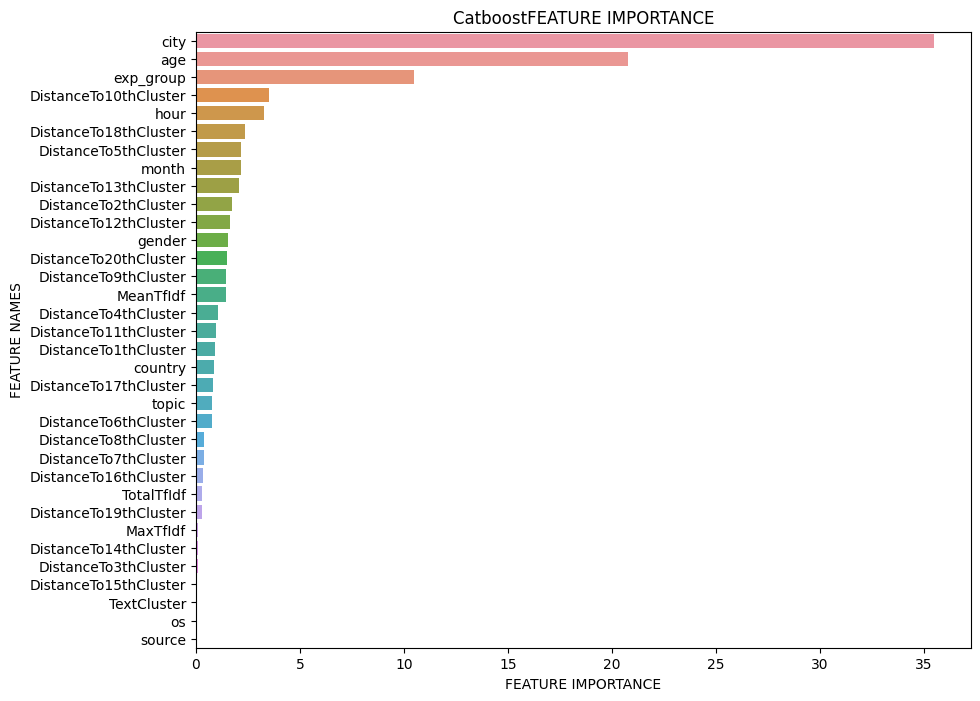

In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')